In [62]:
import matplotlib.pyplot as plt
from imp import reload
from typing import List
import os
import pickle
import pandas as pd
import numpy as np
import sys

sys.path.insert(1, os.path.join(sys.path[0], '..'))
from data_utils import DataHandler
import evaluate
import histogram_processing
import similarities
import bg_masks
import image_utils
import detect_textbox

N_PROCESS = 10

## Load Data

In [63]:
data_handler = DataHandler()
db, db_files = data_handler.load_images(folder = "../data/BBDD/", extension = ".jpg", desc = "Loading BBDD Data...")

qsd2_w1, qsd2_w1_files = data_handler.load_images(folder = "../data/qsd2_w1/", extension = ".jpg", desc = "Loading qsd2_w1 Data...")
qsd1_w2, qsd1_w2_files = data_handler.load_images(folder = "../data/qsd1_w2/", extension = ".jpg", desc = "Loading qsd1_w2 Data...")

# # Test W2
# qst1_w2, qst2_w2_files = data_manager.load_images(folder = "../data/qst1_w2/", extension = ".jpg", desc = "Loading qst1_w2 Data...")
# qst2_w2, qst2_w2_files = data_manager.load_images(folder = "../data/qst2_w2/", extension = ".jpg", desc = "Loading qst2_w2 Data...")

Initialized DataHandler with 2 processes


Loading BBDD Data...:   0%|          | 1/287 [00:00<00:31,  8.95it/s]Exception ignored in: <function _releaseLock at 0x7f3fa4e5b940>
Traceback (most recent call last):
  File "/usr/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Loading BBDD Data...:  67%|██████▋   | 192/287 [00:20<00:04, 23.03it/s]

KeyboardInterrupt: 

In [ ]:
qsd2_w2, qsd2_w2_files = data_handler.load_images(folder="../data/qsd2_w2/", extension=".jpg", desc="Loading qsd2_w2 Data...")
qsd2_w2_masks, qsd2_w2_masks_files = data_handler.load_images(folder="../data/qsd2_w2/", extension=".png", desc="Loading qsd2_w2 Masks...")

Loading qsd2_w2 Data...: 100%|██████████| 30/30 [00:02<00:00, 12.12it/s]


../data/qsd2_w2/ read: 30 images


Loading qsd2_w2 Masks...: 100%|██████████| 30/30 [00:00<00:00, 35.32it/s]

../data/qsd2_w2/ read: 30 images


## Task 1

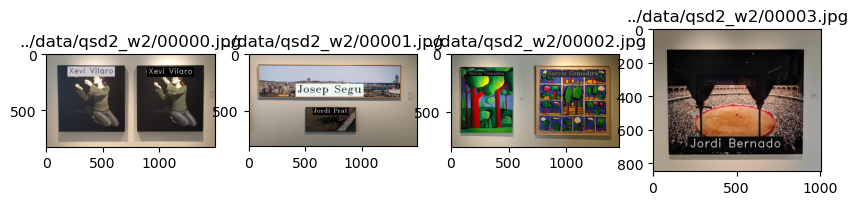

In [ ]:
f, axarr = plt.subplots(1, 4, figsize=(10, 10))
for img, filename in zip(qsd2_w2[:4], qsd2_w2_files[:4]):
    axarr[qsd2_w2_files.index(filename)].imshow(img)
    axarr[qsd2_w2_files.index(filename)].title.set_text(filename)
plt.show()

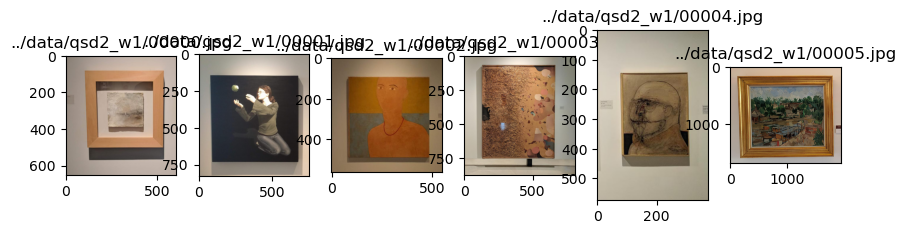

In [ ]:
f, axarr = plt.subplots(1, 6, figsize=(10, 10))
for img, filename in zip(qsd2_w1[:6], qsd2_w1_files[:6]):
    axarr[qsd2_w1_files.index(filename)].imshow(img)
    axarr[qsd2_w1_files.index(filename)].title.set_text(filename)
plt.show()

In [ ]:
bg_masks.generate_masks(query_images_paths=qsd2_w1_files, output_dir='../data/otsu_masks_w1/', method="otsu", th=92)
masks_gen_otsu, masks_gen_mean_otsu = data_handler.load_images(
    folder=f".././data/otsu_masks_w1/", extension=".png", desc=f"Loading 'otsu' masks Data...")
imgs_cropped_qsd2_w1 = [image_utils.crop_image(img, mask) for img, mask in zip(qsd2_w1, masks_gen_otsu)]

Generating masks with Otsu's method:  13%|█▎        | 4/30 [00:00<00:00, 34.05it/s]/Users/johnny/Projects/Team1/week2/../bg_masks.py:246: RuntimeWarning: invalid value encountered in double_scalars
  m0 = np.sum(prob[:t] * bin_mids[:t]) / w0
/Users/johnny/Projects/Team1/week2/../bg_masks.py:246: RuntimeWarning: invalid value encountered in double_scalars
  m0 = np.sum(prob[:t] * bin_mids[:t]) / w0
/Users/johnny/Projects/Team1/week2/../bg_masks.py:246: RuntimeWarning: invalid value encountered in double_scalars
  m0 = np.sum(prob[:t] * bin_mids[:t]) / w0
/Users/johnny/Projects/Team1/week2/../bg_masks.py:246: RuntimeWarning: invalid value encountered in double_scalars
  m0 = np.sum(prob[:t] * bin_mids[:t]) / w0
Loading 'otsu' masks Data...: 100%|██████████| 30/30 [00:01<00:00, 19.98it/s]

.././data/otsu_masks_w1/ read: 30 images


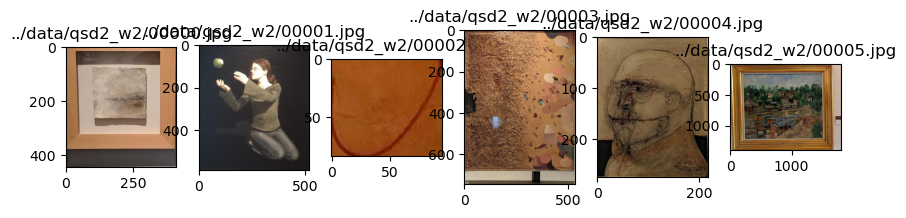

In [ ]:
f, axarr = plt.subplots(1, 6, figsize=(10, 10))
for img, filename in zip(imgs_cropped_qsd2_w1[:6], qsd2_w2_files[:6]):
    axarr[qsd2_w2_files.index(filename)].imshow(img)
    axarr[qsd2_w2_files.index(filename)].title.set_text(filename)
plt.show()

### Find best hyperparameters for new descriptors based on qsd2_w1

In [ ]:
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd

colorspaces = ('grayscale', 'RGB', 'CieLab', 'YCbCr', 'HSV')
n_bins_vals = (4, 6, 8)
n_levels_vals = (2, 3)

def compute_features_experiments(dataset, query_images, query_dataset_name="qsd2_w1", db_dataset_name="DDBB"):
    for colorspace in colorspaces:
        for n_bins in n_bins_vals:
            for n_levels in n_levels_vals:
                query_features = histogram_processing.generate_feature_matrix(
                    query_images,
                    mssg="Generating features for query dataset...(with N_PROCESS = {})".format(N_PROCESS),
                    n_levels=n_levels,
                    n_bins=n_bins,
                    grayscale=colorspace=="grayscale",
                    RGB=colorspace=="RGB",
                    CieLab=colorspace=="CieLab",
                    HSV=colorspace=="HSV",
                    YCbCr=colorspace=="YCbCr",
                    histogram3d=True,
                    N_PROCESS=N_PROCESS,
                )
                data_handler.save_object_pickle(
                    query_features,
                    f"../results/data/w2/features_3dhistogram_{query_dataset_name}_{colorspace}_{n_bins}_{n_levels}.pkl",
                )
                del query_features

                db_feature_matrix = histogram_processing.generate_feature_matrix(
                    dataset=dataset,
                    n_levels=n_levels,
                    n_bins=n_bins,
                    grayscale=colorspace=="grayscale",
                    RGB=colorspace=="RGB",
                    CieLab=colorspace=="CieLab",
                    HSV=colorspace=="HSV",
                    YCbCr=colorspace=="YCbCr",
                    histogram3d=True,
                    mssg=f"Generating features for {db_dataset_name} dataset...(with N_PROCESS = {N_PROCESS})",
                    N_PROCESS=N_PROCESS,
                )
                data_handler.save_object_pickle(
                    db_feature_matrix,
                    f"../results/data/w2/features_3dhistogram_{db_dataset_name}_{colorspace}_{n_bins}_{n_levels}.pkl",
                )
                del db_feature_matrix


measures = {
    'euclidean_distance': similarities.euclidean_distance,
    'l1_distance': similarities.l1_distance,
    'chi_square_distance': similarities.chi_square_distance,
    'histogram_intersection': similarities.histogram_intersection,
    'hellinger_kernel': similarities.hellinger_kernel,
    'cosine_similarity': similarities.cosine_similarity,
    'histogram_correlation': similarities.histogram_correlation,
}

distance_measures = (
    'euclidean_distance', 'l1_distance', 'chi_square_distance',
    'histogram_intersection', 'hellinger_kernel', 'cosine_similarity', 'histogram_correlation'
)

def run_experiments(query_dataset_name="qsd2_w1", db_dataset_name="DDBB"):

    eval_data = []
    for colorspace in colorspaces:
        for n_bins in n_bins_vals:
            for n_levels in n_levels_vals:
                for distance_name in distance_measures:
                    print("*"*100)
                    print(f"Evaluating {query_dataset_name}_{db_dataset_name}_{colorspace}_{n_bins}_{n_levels} with distance measure {distance_name}")
                    if not os.path.isfile(f"../results/data/w2/dist_{query_dataset_name}_{db_dataset_name}_{colorspace}_{n_bins}_{n_levels}_{distance_name}.pkl"):
                        print("if not os.path.isfile(f\"../results/data/w2/dist_{query_dataset_name}_{db_dataset_name}_{colorspace}_{n_bins}_{n_levels}_{distance_name}.pkl\"):")
                        query_features = data_handler.load_object_pickle(
                            f"../results/data/w2/features_3dhistogram_{query_dataset_name}_{colorspace}_{n_bins}_{n_levels}.pkl"
                        )
                        db_feature_matrix = data_handler.load_object_pickle(
                            f"../results/data/w2/features_3dhistogram_{db_dataset_name}_{colorspace}_{n_bins}_{n_levels}.pkl"
                        )
                        dist = Parallel(n_jobs=N_PROCESS)(delayed(similarities.compute_similarities)(
                            query_img, db_feature_matrix, measures[distance_name], n_bins)
                                for query_img in
                                    tqdm(
                                        query_features,
                                        desc=f"Computing similarities for {query_dataset_name}_{db_dataset_name}_{colorspace}_{n_bins}_{n_levels} with distance measure {distance_name}",
                                    )
                        )
                        data_handler.save_object_pickle(
                            dist, f"../results/data/w2/dist_{query_dataset_name}_{db_dataset_name}_{colorspace}_{n_bins}_{n_levels}_{distance_name}.pkl"
                        )
                    else:
                        dist = data_handler.load_object_pickle(
                            f"../results/data/w2/dist_{query_dataset_name}_{db_dataset_name}_{colorspace}_{n_bins}_{n_levels}_{distance_name}.pkl"
                        )
                    for k in (1,5,10):
                        top_k = evaluate.get_top_k(
                            similarity_matrix=dist, db_files=db_files,
                            k=k, mssg=f"Retrieving top K similar images for qs1, distance measure {distance_name} and color space {colorspace}..."
                        )

                        predicted_results = data_handler.store_outputs_single(
                            top_k,
                            f"../results/data/w2/pred_{query_dataset_name}_{db_dataset_name}_{colorspace}_{n_bins}_{n_levels}_{distance_name}.pkl",
                            save=True
                        )
                        expected_results = pickle.load(open(f'../data/{query_dataset_name}/gt_corresps.pkl', "rb"))

                        mapk = evaluate.mapk(expected_results, predicted_results, k=k)

                        print("MAP@{} Score: {:.4f}% ({}/{})".format(k, mapk*100, int(len(predicted_results)*mapk), len(predicted_results)))
                        eval_data.append([colorspace, n_bins, n_levels, distance_name, k, mapk*100, int(len(predicted_results)*mapk), len(predicted_results)])

    dataframe = pd.DataFrame(eval_data, columns=['Color space', 'Distance', 'Num Bins', 'Num Levels', 'K', 'MapK', 'correct', 'total'])
    dataframe.to_csv(f"../results/eval_colorspace_distance_n_bins_n_levels_{query_dataset_name}_{db_dataset_name}_w2.csv", index=False)

## Task 2

In [ ]:
# compute_features_experiments(db[:], imgs_cropped_qsd2_w1[:], query_dataset_name="qsd2_w1", db_dataset_name="DDBB")
# run_experiments(query_dataset_name="qsd2_w1", db_dataset_name="DDBB")

In [ ]:
qs1_w2_similarity_matrix = similarities.compute_similarities_batch(
    qsd1_w2[:], db[:],
    'hellinger_kernel', n_levels=3, n_bins=6,
    grayscale=False, RGB=True, CieLab=False, HSV=True, YCbCr=False, histogram3d=True,
    mssg="Computing similarities for qsd1...(with N_PROCESS = {})".format(N_PROCESS),
    N_PROCESS=N_PROCESS
)

Generating features for query dataset...(with N_PROCESS = 10): 100%|██████████| 5/5 [00:00<00:00, 297.26it/s]


query_features.shape (5, 64)


Generating features for BBDD dataset...(with N_PROCESS = 10): 100%|██████████| 10/10 [00:00<00:00, 316.22it/s]


db_feature_matrix.shape (10, 64)


Computing similarities for qsd1...(with N_PROCESS = 10): 100%|██████████| 5/5 [00:00<00:00, 1007.81it/s]


In [ ]:
top_k_qs1_w2 = evaluate.get_top_k(
    similarity_matrix=qs1_w2_similarity_matrix,
    db_files=db_files,
    k=10,
    mssg="Retrieving top K similar images for qs1..."
)
top_1_qs1_w2 = evaluate.get_top_k(similarity_matrix=qs1_w2_similarity_matrix, db_files=db_files,
                                    k=1, mssg="Retrieving top 1 similar images for qsd1...")
top_5_qs1_w2 = evaluate.get_top_k(similarity_matrix=qs1_w2_similarity_matrix, db_files=db_files,
                                    k=5, mssg="Retrieving top 5 similar images for qsd1...")

Retrieving top K similar images for qs1...: 100%|██████████| 5/5 [00:00<00:00, 8338.58it/s]


[['../data/BBDD/bbdd_00005.jpg',
  '../data/BBDD/bbdd_00000.jpg',
  '../data/BBDD/bbdd_00009.jpg',
  '../data/BBDD/bbdd_00008.jpg',
  '../data/BBDD/bbdd_00002.jpg',
  '../data/BBDD/bbdd_00003.jpg',
  '../data/BBDD/bbdd_00004.jpg',
  '../data/BBDD/bbdd_00007.jpg',
  '../data/BBDD/bbdd_00006.jpg',
  '../data/BBDD/bbdd_00001.jpg'],
 ['../data/BBDD/bbdd_00007.jpg',
  '../data/BBDD/bbdd_00000.jpg',
  '../data/BBDD/bbdd_00003.jpg',
  '../data/BBDD/bbdd_00009.jpg',
  '../data/BBDD/bbdd_00004.jpg',
  '../data/BBDD/bbdd_00006.jpg',
  '../data/BBDD/bbdd_00001.jpg',
  '../data/BBDD/bbdd_00002.jpg',
  '../data/BBDD/bbdd_00008.jpg',
  '../data/BBDD/bbdd_00005.jpg'],
 ['../data/BBDD/bbdd_00009.jpg',
  '../data/BBDD/bbdd_00004.jpg',
  '../data/BBDD/bbdd_00003.jpg',
  '../data/BBDD/bbdd_00000.jpg',
  '../data/BBDD/bbdd_00008.jpg',
  '../data/BBDD/bbdd_00007.jpg',
  '../data/BBDD/bbdd_00002.jpg',
  '../data/BBDD/bbdd_00005.jpg',
  '../data/BBDD/bbdd_00006.jpg',
  '../data/BBDD/bbdd_00001.jpg'],
 ['../d

In [ ]:
predicted_results_qs1_w2 = data_handler.store_outputs_single(top_k_qs1_w2, "./QST1/histograms", save=True)
expected_results_qs1_w2 = pickle.load(open('../data/qsd1_w2/gt_corresps.pkl', "rb"))
print(predicted_results_qs1_w2)
print(expected_results_qs1_w2)
mapk_qs10 = evaluate.mapk(expected_results_qs1_w2, predicted_results_qs1_w2, k=10)

print("MAP@K Score: {:.4f}% ({}/{})".format(mapk_qs10*100,
      int(len(predicted_results_qs1_w2)*mapk_qs10), len(predicted_results_qs1_w2)))

Results saved at ./QST1/histograms/result.pkl
[[5 0 9 8 2 3 4 7 6 1]
 [7 0 3 9 4 6 1 2 8 5]
 [9 4 3 0 8 7 2 5 6 1]
 [9 4 3 0 2 7 8 5 6 1]
 [9 4 8 3 2 0 6 5 7 1]]
[[77], [136], [130], [58], [219], [48], [90], [248], [45], [212], [93], [270], [91], [258], [259], [221], [52], [182], [95], [272], [241], [260], [41], [250], [274], [160], [104], [11], [223], [22]]


In [ ]:
predicted_results_qs1_w2 = data_handler.store_outputs_single(top_1_qs1_w2, "./QST1/histograms/1", save=True)
expected_results_qs1_w2 = pickle.load(open('../data/qsd1_w2/gt_corresps.pkl', "rb"))

mapk_qs1 = evaluate.mapk(expected_results_qs1_w2, predicted_results_qs1_w2, k=1)

print("MAP@K Score: {:.4f}% ({}/{})".format(mapk_qs1*100,
      int(len(predicted_results_qs1_w2)*mapk_qs1), len(predicted_results_qs1_w2)))

Results saved at ./QST1/histograms/1/result.pkl
MAP@K Score: 0.0000% (0/30)


In [ ]:
predicted_results_qs1_w2 = data_handler.store_outputs_single(top_5_qs1_w2, "./QST1/histograms/5", save=True)
expected_results_qs1_w2 = pickle.load(open('../data/qsd1_w2/gt_corresps.pkl', "rb"))

mapk_qs5 = evaluate.mapk(expected_results_qs1_w2, predicted_results_qs1_w2, k=5)

print("MAP@K Score: {:.4f}% ({}/{})".format(mapk_qs5*100,
      int(len(predicted_results_qs1_w2)*mapk_qs5), len(predicted_results_qs1_w2)))

Results saved at ./QST1/histograms/5/result.pkl
MAP@K Score: 0.0000% (0/30)


# TASK 5

In [ ]:
masks_text_qsd1_w2, masks_text_qsd1_w2_files = data_handler.load_images(
    folder=f"../results/text_removal_results/qsd1_w2/",
    extension=".png",
    desc=f"Loading background text masks for QSD1-W2..."
)

Loading background text masks for QSD1-W2...: 100%|██████████| 30/30 [00:01<00:00, 16.62it/s]

../results/text_removal_results/qsd1_w2/ read: 30 images


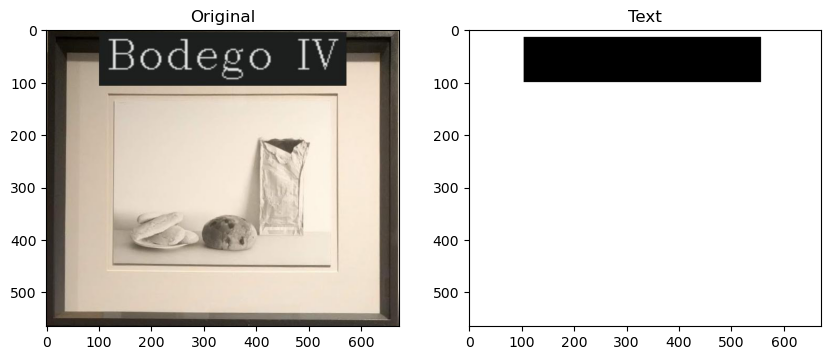

In [ ]:
# plot two images together
from matplotlib.pyplot import plot


def plot_two_images(img1, img2, title1, title2, cmap1=None, cmap2=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    ax1.imshow(img1, cmap=cmap1)
    ax1.set_title(title1)
    ax2.imshow(img2, cmap=cmap2)
    ax2.set_title(title2)
    plt.show()

# plot two imatges together
plot_two_images(qsd1_w2[0], masks_text_qsd1_w2[0], "Original", "Text", cmap1="gray", cmap2="gray")

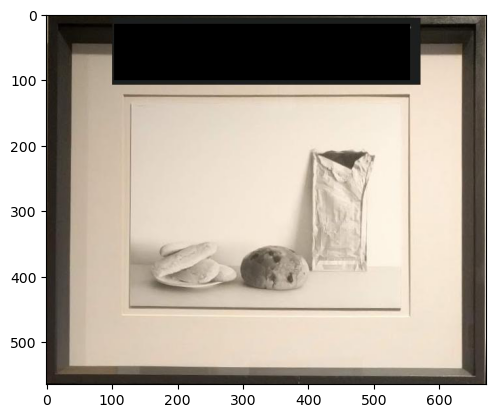

In [ ]:
# apply mask binary to image rgb
def apply_mask(img, mask):
    img_copy = img.copy()
    img_copy[mask == 0] = 0
    plt.imshow(img_copy)

apply_mask(qsd1_w2[0], masks_text_qsd1_w2[0])

In [ ]:
# TODO: use best set of hyperparameters
similarity_matrix_qsd1_w2 = similarities.compute_similarities_batch(
    qsd1_w2[:], db[:], 'hellinger_kernel',
    n_levels=3, n_bins=8, grayscale=False, RGB=True, CieLab=False, HSV=False, YCbCr=False, histogram3d=True,
    mssg="Computing similarities for qsd1-w2 cropped...(with N_PROCESS = {})".format(N_PROCESS),
    N_PROCESS=N_PROCESS,
    masks_queries=masks_text_qsd1_w2[:],
    masks_database=None,
)

Generating features for query dataset...(with N_PROCESS = 10): 100%|██████████| 30/30 [00:02<00:00, 14.09it/s]


query_features.shape (30, 512)


Generating features for BBDD dataset...(with N_PROCESS = 10): 100%|██████████| 287/287 [00:32<00:00,  8.85it/s]


db_feature_matrix.shape (287, 512)


Computing similarities for qsd1-w2 cropped...(with N_PROCESS = 10): 100%|██████████| 30/30 [00:00<00:00, 72.74it/s]


In [ ]:
top_1_qsd1_w2 = evaluate.get_top_k(similarity_matrix=similarity_matrix_qsd1_w2, db_files=db_files,
                                    k=1, mssg="Retrieving top 1 similar images for qsd1_w2...")
top_5_qsd1_w2 = evaluate.get_top_k(similarity_matrix=similarity_matrix_qsd1_w2, db_files=db_files,
                                    k=5, mssg="Retrieving top 5 similar images for qsd1_w2...")

Retrieving top 5 similar images for qsd1_w2...: 100%|██████████| 30/30 [00:00<00:00, 26247.21it/s]


In [ ]:
predicted_results_1 = data_handler.store_outputs_single(top_1_qsd1_w2, "./QSD1/task5", save=True)
expected_results = pickle.load(open('../data/qsd1_w2/gt_corresps.pkl', "rb"))

mapk_qs1_1 = evaluate.mapk(expected_results, predicted_results_1, k=1)

print("MAP@1 Score: {:.4f}% ({}/{})".format(mapk_qs1_1*100,
      int(len(predicted_results_1)*mapk_qs1_1), len(predicted_results_1)))

Results saved at ./QSD1/task5/result.pkl
MAP@1 Score: 40.0000% (12/30)


In [ ]:
predicted_results_5 = data_handler.store_outputs_single(top_5_qsd1_w2, "./QSD1/task5", save=True)
expected_results = pickle.load(open('../data/qsd1_w2/gt_corresps.pkl', "rb"))

mapk_qs1_5 = evaluate.mapk(expected_results, predicted_results_5, k=1)

print("MAP@5 Score: {:.4f}% ({}/{})".format(mapk_qs1_5*100,
      int(len(predicted_results_5)*mapk_qs1_5), len(predicted_results_5)))

Results saved at ./QSD1/task5/result.pkl
MAP@5 Score: 40.0000% (12/30)


In [ ]:
eval_data = [
    [1, mapk_qs1_1, int(len(predicted_results_1)*mapk_qs1_1), len(predicted_results_1) ],
    [5, mapk_qs1_5, int(len(predicted_results_5)*mapk_qs1_5), len(predicted_results_5) ]
]
dataframe = pd.DataFrame(eval_data, columns=['K', 'MapK', 'correct', 'total'])
dataframe.to_csv("../results/task5/task5.csv", index=False)

## Task 6

In [ ]:
# This code generates masks for the QSD2-W2 dataset.
bg_masks.generate_masks_floodFill(
    qsd2_w2[:],
    two_components=True,
    N_PROCESS=N_PROCESS,
    mssg="Generating masks with floodfill method and up to two components...",
    image_files=qsd2_w2_files[:],
    output_dir='../data/floodFill_masks_qsd2_w2/',
)


Generating masks with floodfill method and up to two components...: 100%|██████████| 30/30 [00:46<00:00,  1.56s/it]


[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 arr

In [ ]:
# load background masks
masks_gen_floodFill_qsd2_w2, masks_gen_floodFill_qsd2_w2_files = data_handler.load_images(
    folder=f"../data/floodFill_masks_qsd2_w2/",
    extension=".png",
    desc=f"Loading background masks for QSD2-W2..."
)

Loading background masks for QSD2-W2...: 100%|██████████| 30/30 [00:04<00:00,  6.04it/s]


../data/floodFill_masks_qsd2_w2/ read: 30 images


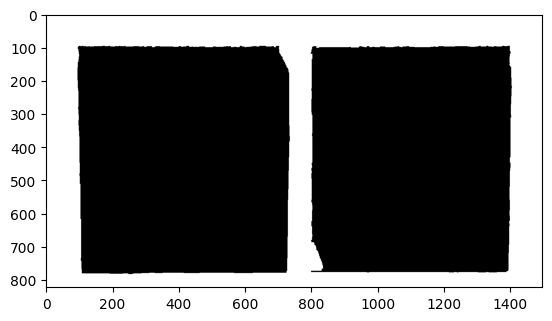

In [ ]:
plt.imshow(masks_gen_floodFill_qsd2_w2[0], cmap='binary')

In [ ]:
# combine background and text masks
# masks_overlap = [1-np.logical_and(mask1.astype(bool), (mask2).astype(bool)) for mask1, mask2 in zip(masks_gen_floodFill_qsd2_w2, masks_text_qsd2_w2)]

In [ ]:
reload(image_utils)
bboxes_qsd2_w2 = image_utils.crop_paintings_batch(qsd2_w2, qsd2_w2_files, masks_gen_floodFill_qsd2_w2, output_dir="../results/cropped_paintings_qsd2_w2/", extract_text_mask=True)
data_handler.save_object_pickle(bboxes_qsd2_w2, "./QSD2/text_boxes.pkl")

Done cropping paintings.
Object saved at ./QSD2/text_boxes.pkl


In [ ]:
bboxes_qsd2_w2

[[[196, 115, 540, 100], [898, 118, 511, 104]],
 [[285, 286, 1238, 237], [562, 475, 394, 79]],
 [[148, 138, 414, 97], [880, 232, 470, 190]],
 [[223, 648, 696, 612]],
 [[2037, 344, 3020, 394]],
 [[639, 1740, 1177, 1579], [2777, 180, 1172, 166]],
 [[192, 98, 389, 72], [779, 100, 464, 75]],
 [[236, 124, 574, 82]],
 [[146, 157, 397, 97], [945, 600, 419, 574]],
 [[160, 557, 348, 532], [677, 123, 407, 102]],
 [[519, 1555, 1038, 1558], [2827, 1075, 719, 533]],
 [[171, 64, 381, 74], [624, 334, 225, 240]],
 [[431, 208, 1207, 138], [2039, 119, 1102, 95]],
 [[587, 1692, 1120, 1519], [2610, 1852, 1128, 1829]],
 [[635, 1480, 1147, 1434], [2724, 195, 1146, 173]],
 [[3226, 699, 3270, 766]],
 [[189, 179, 620, 115], [1022, 176, 465, 115]],
 [[182, 280, 727, 183], [2204, 1302, 1539, 1223]],
 [[98, 224, 268, 68], [541, 602, 356, 529]],
 [[358, 1547, 870, 1231], [2295, 1658, 1266, 1619]],
 [[188, 169, 405, 75], [972, 140, 457, 77]],
 [[2537, 1699, 3137, 1781]],
 [[102, 89, 312, 81], [102, 89, 240, 57]],
 [

In [ ]:
reload(histogram_processing)
feats_multiple_qsd2_w2 = histogram_processing.compute_features_multiple(
    "../results/cropped_paintings_qsd2_w2",
    n_levels=3, n_bins=6,
    grayscale = False, RGB = True, CieLab = False, HSV = False, YCbCr = False,
    histogram3d = True,
)

In [ ]:
feats_multiple_qsd2_w2

[[array([7.47771340e-07, 3.86411789e-07, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
  array([1.16137147e-05, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00])],
 [array([1.40421850e-06, 8.97291871e-08, 8.65554859e-10, ...,
         0.00000000e+00, 9.16032772e-08, 2.49385249e-06]),
  array([1.05281363e-05, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00])],
 [array([8.00772750e-06, 1.93642572e-07, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
  array([1.51777588e-06, 3.16777181e-07, 5.50916836e-09, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00])],
 [array([1.12504830e-05, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 9.12231537e-07])],
 [array([1.69823617e-06, 3.57552312e-07, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00])],
 [array([9.96334699e-07, 0.

In [ ]:
reload(similarities)
reload(histogram_processing)
db_feature_matrix = similarities.generate_feature_matrix(
    dataset=db[:],
    n_levels=3, n_bins=6,
    grayscale=False,
    RGB=True,
    CieLab=False,
    HSV=False,
    YCbCr=False,
    histogram3d=True,
    mssg="Generating features for BBDD dataset...(with N_PROCESS = {})".format(
        N_PROCESS),
    masks=None,
    N_PROCESS=N_PROCESS,
)

Generating features for BBDD dataset...(with N_PROCESS = 10): 100%|██████████| 287/287 [01:59<00:00,  2.41it/s]


In [ ]:
similarities_multiple = similarities.compute_similarities_multiple(
    features_multiple=feats_multiple_qsd2_w2,
    db_features=db_feature_matrix,
    similarity_measure="hellinger_kernel",
    n_bins=6
)
similarities_multiple

[[array([ 1.84250531e-03,  3.27479073e-04,  1.82809787e-03,  1.16458534e-03,
          1.15076589e-03,  1.74962009e-03,  7.30193554e-04,  1.37159148e-03,
          9.15799012e-04,  1.10230916e-03,  2.00078124e-03,  1.11463210e-03,
          1.07373632e-03,  1.16091862e-03,  1.53139844e-03,  1.00863563e-03,
          1.12525339e-03,  1.42322813e-03,  2.52947217e-03,  6.24462605e-04,
          1.51180698e-03,  1.69065184e-03,  2.21865680e-04,  1.23340408e-03,
          9.71404385e-04,  1.52785344e-04,  1.69239807e-03,  3.60533157e-04,
          1.99589975e-03,  9.43534722e-04, -0.00000000e+00,  4.30148162e-04,
          8.19250704e-04,  1.28301580e-03,  1.05009653e-03,  1.68359287e-03,
          1.21295255e-03,  7.39790006e-04,  1.75123033e-03,  5.77573250e-04,
          1.47811908e-03,  1.97718373e-03,  7.19143396e-04,  7.02276903e-04,
          1.19363205e-03,  1.05115359e-03,  8.63358726e-04,  2.05698989e-03,
          9.29332766e-04,  1.58988971e-03,  4.73581860e-04,  9.11129289e-04,

In [ ]:
top_1_multiple = evaluate.get_top_k_multiple(similarities_multiple, db_files, k=1)
top_5_multiple = evaluate.get_top_k_multiple(similarities_multiple, db_files, k=5)

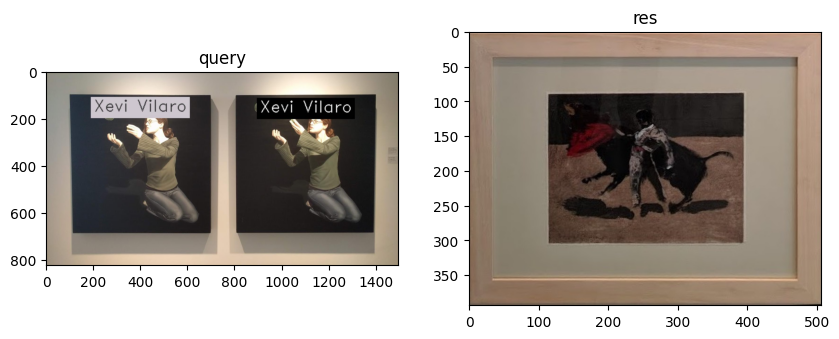

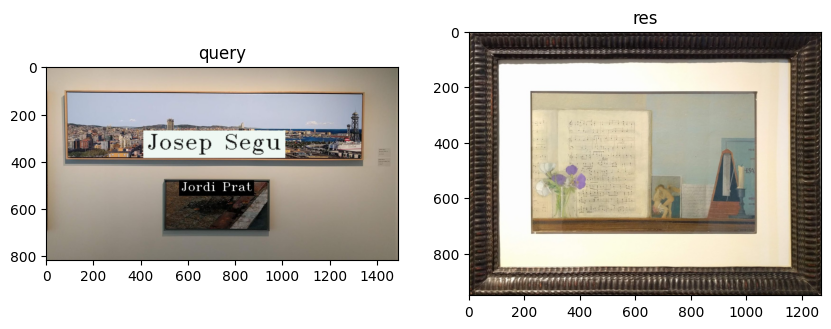

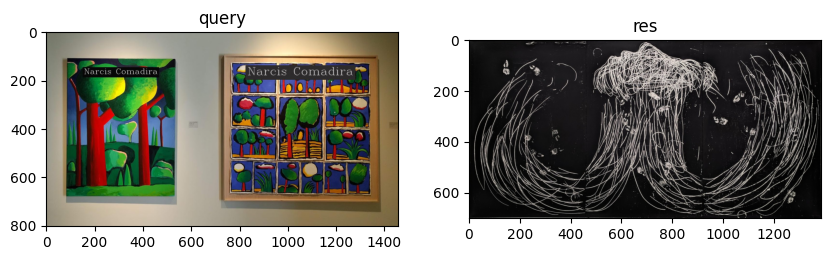

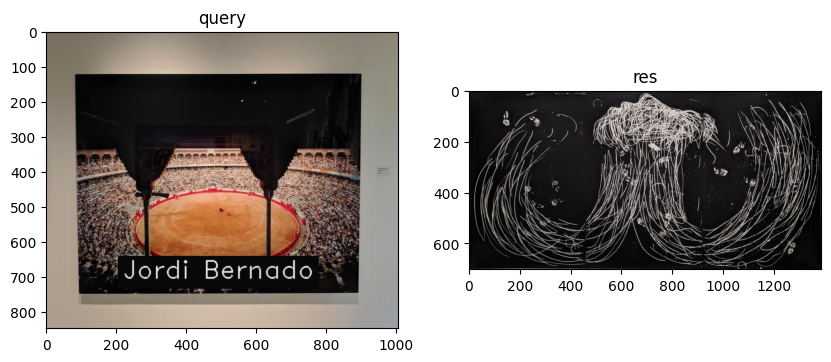

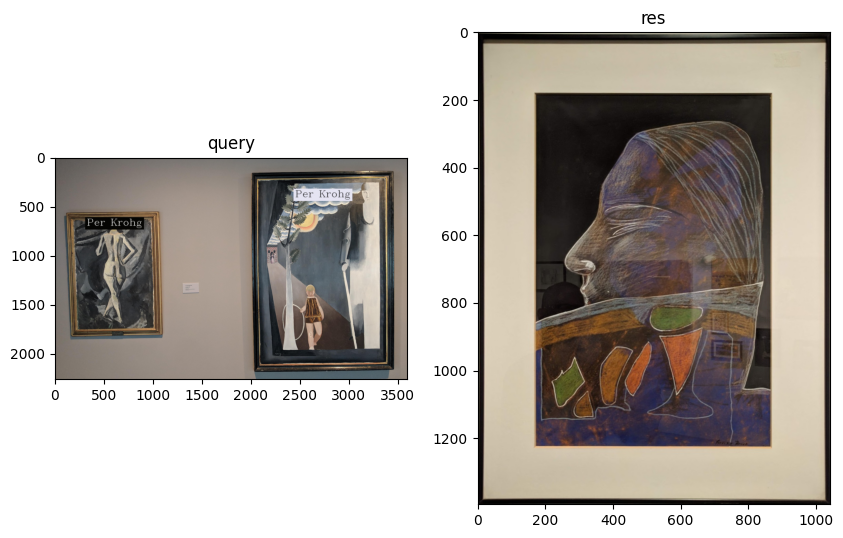

In [ ]:
from skimage.io import imread

def plot_image_and_similar(qs, top_k_qs) -> None:

    for i in range(min(5, len(qs))):
        f, axarr = plt.subplots(1, 2, figsize=(10, 10))
        query = qs[i]
        res = imread(top_k_qs[i][0][0])
        axarr[0].imshow(query)
        axarr[0].title.set_text("query")
        axarr[1].imshow(res)
        axarr[1].title.set_text("res")
        plt.show()

plot_image_and_similar(qsd2_w2, top_1_multiple)

In [ ]:
predicted_results_1_qsd2_w2_multiple = data_handler.store_outputs_multiple(top_1_multiple, "./results/qsd2_w2_multiple/", save=True)
expected_results_qsd2_w2 = pickle.load(open('../data/qsd2_w2/gt_corresps.pkl', "rb"))

mapk1_qsd2_w2_multiple = evaluate.mapk_multiple(expected_results_qsd2_w2, predicted_results_1_qsd2_w2_multiple, k=1)

print("MAP@1 Score: {:.4f}% ({}/{})".format(mapk1_qsd2_w2_multiple*100,
      int(len(predicted_results_1_qsd2_w2_multiple)*mapk1_qsd2_w2_multiple), len(predicted_results_1_qsd2_w2_multiple)))


Results saved at ./results/qsd2_w2_multiple//result.pkl
MAP@1 Score: 5.6604% (1/30)


In [ ]:
predicted_results_5_qsd2_w2_multiple = data_handler.store_outputs_multiple(top_5_multiple, "./results/qsd2_w2_multiple/", save=True)
expected_results_qsd2_w2 = pickle.load(open('../data/qsd2_w2/gt_corresps.pkl', "rb"))

mapk5_qsd2_w2_multiple = evaluate.mapk_multiple(expected_results_qsd2_w2, predicted_results_5_qsd2_w2_multiple, k=5)

print("MAP@5 Score: {:.4f}% ({}/{})".format(mapk5_qsd2_w2_multiple*100,
      int(len(predicted_results_5_qsd2_w2_multiple)*mapk5_qsd2_w2_multiple), len(predicted_results_5_qsd2_w2_multiple)))

Results saved at ./results/qsd2_w2_multiple//result.pkl
MAP@5 Score: 7.4528% (2/30)


In [ ]:
eval_data = [
    [1, mapk1_qsd2_w2_multiple, int(len(predicted_results_1_qsd2_w2_multiple)*mapk1_qsd2_w2_multiple), len(predicted_results_1_qsd2_w2_multiple) ],
    [5, mapk5_qsd2_w2_multiple, int(len(predicted_results_5_qsd2_w2_multiple)*mapk5_qsd2_w2_multiple), len(predicted_results_5_qsd2_w2_multiple) ]
]
dataframe = pd.DataFrame(eval_data, columns=['K', 'MapK', 'correct', 'total'])
dataframe.to_csv("../results/task6/task6.csv", index=False)

# TEST

## TEST 1

In [ ]:
qst1_w2, qst1_w2_files = data_handler.load_images(folder = "../data/Test/qst1_w2/", extension = ".jpg", desc = "Loading qst1_w2 Data...")

In [ ]:
detect_textbox.generate_masks_test('../data/Test/qst1_w2/', '../data/Test/qst1_w2_masks/')

In [ ]:
masks_text_qst1_w2, masks_text_qst1_w2_files = data_handler.load_images(
    folder=f"../data/Test/qst1_w2_masks/",
    extension=".png",
    desc=f"Loading background text masks for qst1_w2 TEST..."
)

In [ ]:
similarity_matrix_qst1_w2 = similarities.compute_similarities_batch(
    qst1_w2[:], db[:], 'hellinger_kernel',
    n_levels=3, n_bins=6, grayscale=False, RGB=True, CieLab=False, HSV=False, YCbCr=False, histogram3d=True,
    mssg="Computing similarities for qsd1-w2 cropped...(with N_PROCESS = {})".format(N_PROCESS),
    N_PROCESS=N_PROCESS,
    masks_queries=masks_text_qst1_w2[:], # MASCARAS HAY QUE CAMBIAR
    masks_database=None,
)

In [ ]:
top_10_qst1_w2 = evaluate.get_top_k(similarity_matrix=similarity_matrix_qst1_w2, db_files=db_files,
                                    k=10, mssg="Retrieving top 10 similar images for qst1_w2...")

predicted_test1 = data_handler.store_outputs_multiple(top_10_qst1_w2, "./week2/Test/qst1_w2/", save=True)

## TEST 2

In [ ]:
qst2_w2, qst2_w2_files = data_handler.load_images(folder = "../data/Test/qst2_w2/", extension = ".jpg", desc = "Loading qst2_w2 Data...")

In [ ]:
bg_masks.generate_masks_floodFill(
    qst2_w2[:],
    two_components=True,
    N_PROCESS=N_PROCESS,
    mssg="Generating masks with floodfill method and up to two components...",
    image_files=qst2_w2_files[:],
    output_dir='../data/floodFill_masks_qst2_w2/',
)

In [ ]:
masks_gen_floodFill_qst2_w2, masks_gen_floodFill_qst2_w2_files = data_handler.load_images(
    folder=f"../data/floodFill_masks_qst2_w2/",
    extension=".png",
    desc=f"Loading background masks for QST2-W2..."
)

In [64]:
reload(image_utils)
bboxes_qst2_w2 = image_utils.crop_paintings_batch(
    qst2_w2, qst2_w2_files,
    masks_gen_floodFill_qst2_w2,
    output_dir="../results/cropped_paintings_qst2_w2/",
    extract_text_mask=True
)
data_handler.save_object_pickle(bboxes_qst2_w2, "./QST2/text_boxes.pkl")

In [ ]:
# TODO: set best hyperparams
feats_multiple_qst2_w2 = histogram_processing.compute_features_multiple(
    "../results/cropped_paintings_qst2_w2",
    n_levels=3, n_bins=6,
    grayscale = False, RGB = True, CieLab = False, HSV = False, YCbCr = False,
    histogram3d = True,
)

In [ ]:
# TODO: set best hyperparams
db_feature_matrix = similarities.generate_feature_matrix(
    dataset=db[:],
    n_levels=3, n_bins=6,
    grayscale=False,
    RGB=True,
    CieLab=False,
    HSV=False,
    YCbCr=False,
    histogram3d=True,
    mssg="Generating features for BBDD dataset...(with N_PROCESS = {})".format(
        N_PROCESS),
    masks=None,
    N_PROCESS=N_PROCESS,
)

In [ ]:
similarities_multiple_qst2_w2 = similarities.compute_similarities_multiple(
    features_multiple=feats_multiple_qst2_w2,
    db_features=db_feature_matrix,
    similarity_measure="hellinger_kernel",
    n_bins=6
)

In [ ]:
top_10_multiple_qst2_w2 = evaluate.get_top_k_multiple(similarities_multiple, db_files, k=10)

In [ ]:
predicted_results_1_qst2_w2_multiple = data_handler.store_outputs_multiple(top_10_multiple_qst2_w2, "./week2/Test/qst2_w2_multiple/", save=True)